In [2]:
# @title 1. Environment Setup (Kafka & Java)
import os
import time
import subprocess

print("☕ Installing Java...")
!apt-get install -y openjdk-11-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

print("📥 Downloading Kafka...")
!wget -q https://archive.apache.org/dist/kafka/3.6.0/kafka_2.13-3.6.0.tgz
!tar -xzf kafka_2.13-3.6.0.tgz

print("🐍 Installing Python Libraries...")
!pip install -q kafka-python pandas matplotlib

# Start Zookeeper & Kafka
print("🚀 Starting Zookeeper & Kafka...")
subprocess.Popen(["kafka_2.13-3.6.0/bin/zookeeper-server-start.sh", "kafka_2.13-3.6.0/config/zookeeper.properties"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
time.sleep(5)
subprocess.Popen(["kafka_2.13-3.6.0/bin/kafka-server-start.sh", "kafka_2.13-3.6.0/config/server.properties"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
time.sleep(10)

print("✅ Ready for Orchestration.")

☕ Installing Java...
📥 Downloading Kafka...
🐍 Installing Python Libraries...
🚀 Starting Zookeeper & Kafka...
✅ Ready for Orchestration.


In [3]:
# @title 2. Orchestration Configuration
from kafka import KafkaProducer, KafkaConsumer
from kafka.admin import KafkaAdminClient, NewTopic
import json
import uuid
import threading
import random
from datetime import datetime

BOOTSTRAP_SERVERS = ['localhost:9092']
TOPIC_COMMANDS = 'sys_commands'   # Orchestrator -> Services
TOPIC_REPLIES = 'sys_replies'     # Services -> Orchestrator

# Create Topics
admin_client = KafkaAdminClient(bootstrap_servers=BOOTSTRAP_SERVERS, client_id='admin')
try:
    topic_list = [
        NewTopic(name=TOPIC_COMMANDS, num_partitions=1, replication_factor=1),
        NewTopic(name=TOPIC_REPLIES, num_partitions=1, replication_factor=1)
    ]
    admin_client.create_topics(new_topics=topic_list, validate_only=False)
    print("✅ Command & Reply topics created.")
except:
    print("ℹ️ Topics exist.")

# Serializers
def json_serializer(data): return json.dumps(data).encode('utf-8')
def json_deserializer(data): return json.loads(data.decode('utf-8'))

✅ Command & Reply topics created.


In [4]:
# @title 3. Define Worker Services (Payment & Inventory)

class WorkerService(threading.Thread):
    def __init__(self, service_name, success_rate):
        threading.Thread.__init__(self)
        self.service_name = service_name
        self.success_rate = success_rate
        self.running = True
        self.consumer = KafkaConsumer(
            TOPIC_COMMANDS,
            bootstrap_servers=BOOTSTRAP_SERVERS,
            value_deserializer=json_deserializer,
            group_id=f'{service_name}_group'
        )
        self.producer = KafkaProducer(
            bootstrap_servers=BOOTSTRAP_SERVERS,
            value_serializer=json_serializer
        )

    def run(self):
        print(f"👷 {self.service_name} online...")
        while self.running:
            msg_pack = self.consumer.poll(timeout_ms=1000)
            for tp, messages in msg_pack.items():
                for message in messages:
                    cmd = message.value

                    # Filter: Only process commands meant for THIS service
                    if cmd['target_service'] != self.service_name:
                        continue

                    print(f"⚙️ [{self.service_name}] Processing Order: {cmd['order_id']}")
                    time.sleep(random.uniform(0.5, 1.0)) # Simulate work

                    # Logic: Succeed or Fail
                    status = "SUCCESS" if random.random() < self.success_rate else "FAILURE"

                    reply = {
                        "order_id": cmd['order_id'],
                        "service": self.service_name,
                        "command_type": cmd['command_type'],
                        "status": status,
                        "timestamp": datetime.now().isoformat()
                    }

                    self.producer.send(TOPIC_REPLIES, reply)

    def stop(self):
        self.running = False

print("✅ Worker Classes Defined")

✅ Worker Classes Defined


In [5]:
# @title 4. Define The Central Orchestrator
class OrderOrchestrator(threading.Thread):
    def __init__(self):
        threading.Thread.__init__(self)
        self.running = True
        self.state_store = {} # Simulating a database (Order ID -> Current State)
        self.producer = KafkaProducer(
            bootstrap_servers=BOOTSTRAP_SERVERS,
            value_serializer=json_serializer
        )
        self.consumer = KafkaConsumer(
            TOPIC_REPLIES,
            bootstrap_servers=BOOTSTRAP_SERVERS,
            value_deserializer=json_deserializer,
            group_id='orchestrator_group'
        )
        self.completed_sagas = []

    def start_saga(self, order_id, amount):
        # 1. Initialize State
        self.state_store[order_id] = "PENDING_PAYMENT"
        print(f"🎼 [Orchestrator] Starting Saga for {order_id}")

        # 2. Command: Ask Payment Service to charge
        command = {
            "order_id": order_id,
            "target_service": "PAYMENT",
            "command_type": "CHARGE_CARD",
            "payload": {"amount": amount}
        }
        self.producer.send(TOPIC_COMMANDS, command)

    def run(self):
        print("🧠 Orchestrator Brain Online...")
        while self.running:
            msg_pack = self.consumer.poll(timeout_ms=500)
            for tp, messages in msg_pack.items():
                for message in messages:
                    reply = message.value
                    self.handle_reply(reply)

    def handle_reply(self, reply):
        order_id = reply['order_id']
        current_state = self.state_store.get(order_id)

        # --- LOGIC: TRANSITION STATE MACHINE ---

        # Case 1: Payment Reply Received
        if reply['service'] == "PAYMENT":
            if reply['status'] == "SUCCESS":
                print(f"🎼 [Orchestrator] Payment OK for {order_id}. Triggering Inventory...")
                self.state_store[order_id] = "PENDING_INVENTORY"

                # Command: Ask Inventory to Ship
                cmd = {
                    "order_id": order_id,
                    "target_service": "INVENTORY",
                    "command_type": "SHIP_ITEMS",
                    "payload": {}
                }
                self.producer.send(TOPIC_COMMANDS, cmd)

            else:
                print(f"🛑 [Orchestrator] Payment FAILED for {order_id}. Saga Aborted.")
                self.state_store[order_id] = "FAILED_PAYMENT"
                self.log_completion(order_id, "FAILED")

        # Case 2: Inventory Reply Received
        elif reply['service'] == "INVENTORY":
            if reply['status'] == "SUCCESS":
                print(f"✅ [Orchestrator] Order {order_id} FULLY COMPLETED.")
                self.state_store[order_id] = "COMPLETED"
                self.log_completion(order_id, "SUCCESS")
            else:
                print(f"⚠️ [Orchestrator] Inventory FAILED for {order_id}. Triggering Refund...")
                self.state_store[order_id] = "ROLLBACK_PAYMENT"
                # In a real app, we would send a 'REFUND' command to Payment Service here
                self.log_completion(order_id, "FAILED_NO_STOCK")

    def log_completion(self, order_id, final_status):
        self.completed_sagas.append({
            "order_id": order_id,
            "final_status": final_status,
            "timestamp": datetime.now()
        })

    def stop(self):
        self.running = False

print("✅ Orchestrator Class Defined")

✅ Orchestrator Class Defined


In [6]:
# @title 5. Run the Simulation
# 1. Start Services
orchestrator = OrderOrchestrator()
payment_service = WorkerService("PAYMENT", success_rate=0.8)  # 80% success
inventory_service = WorkerService("INVENTORY", success_rate=0.9) # 90% success

orchestrator.start()
payment_service.start()
inventory_service.start()

# 2. Simulate User Requests
print("\n🔄 Generating Orders...")
for i in range(10):
    order_id = f"ORD-{random.randint(1000,9999)}"
    orchestrator.start_saga(order_id, amount=random.randint(50, 500))
    time.sleep(2) # Wait a bit between orders

# 3. Wait for processing to finish
print("\n⏳ Waiting for active sagas to complete...")
time.sleep(15)

# 4. Shutdown
orchestrator.stop()
payment_service.stop()
inventory_service.stop()

orchestrator.join()
payment_service.join()
inventory_service.join()
print("🛑 Simulation Stopped.")

🧠 Orchestrator Brain Online...
👷 PAYMENT online...
👷 INVENTORY online...

🔄 Generating Orders...
🎼 [Orchestrator] Starting Saga for ORD-2965
🎼 [Orchestrator] Starting Saga for ORD-5546
⚙️ [PAYMENT] Processing Order: ORD-5546
🎼 [Orchestrator] Payment OK for ORD-5546. Triggering Inventory...
⚙️ [INVENTORY] Processing Order: ORD-5546
✅ [Orchestrator] Order ORD-5546 FULLY COMPLETED.
🎼 [Orchestrator] Starting Saga for ORD-6039
⚙️ [PAYMENT] Processing Order: ORD-6039
🎼 [Orchestrator] Payment OK for ORD-6039. Triggering Inventory...
⚙️ [INVENTORY] Processing Order: ORD-6039
✅ [Orchestrator] Order ORD-6039 FULLY COMPLETED.
🎼 [Orchestrator] Starting Saga for ORD-4522
⚙️ [PAYMENT] Processing Order: ORD-4522
🎼 [Orchestrator] Payment OK for ORD-4522. Triggering Inventory...
⚙️ [INVENTORY] Processing Order: ORD-4522
⚠️ [Orchestrator] Inventory FAILED for ORD-4522. Triggering Refund...
🎼 [Orchestrator] Starting Saga for ORD-9101
⚙️ [PAYMENT] Processing Order: ORD-9101
🎼 [Orchestrator] Payment OK for


📊 --- Orchestration Summary ---
final_status
SUCCESS            6
FAILED_NO_STOCK    2
FAILED             1
Name: count, dtype: int64


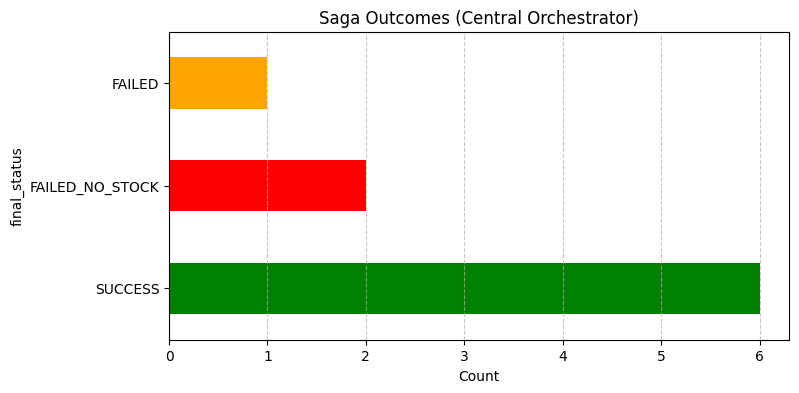


📄 Detailed Logs:
   order_id     final_status                  timestamp
0  ORD-5546          SUCCESS 2026-01-04 05:45:07.343010
1  ORD-6039          SUCCESS 2026-01-04 05:45:09.369051
2  ORD-4522  FAILED_NO_STOCK 2026-01-04 05:45:11.547963
3  ORD-9101          SUCCESS 2026-01-04 05:45:13.370232
4  ORD-5999          SUCCESS 2026-01-04 05:45:15.321651
5  ORD-3934          SUCCESS 2026-01-04 05:45:17.448074
6  ORD-8007           FAILED 2026-01-04 05:45:18.534539
7  ORD-8233          SUCCESS 2026-01-04 05:45:20.900707
8  ORD-2762  FAILED_NO_STOCK 2026-01-04 05:45:23.083407


In [7]:
# @title 6. Orchestration Report
import pandas as pd
import matplotlib.pyplot as plt

data = orchestrator.completed_sagas
if data:
    df = pd.DataFrame(data)

    print("\n📊 --- Orchestration Summary ---")
    print(df['final_status'].value_counts())

    # Visualization
    plt.figure(figsize=(8, 4))
    df['final_status'].value_counts().plot(kind='barh', color=['green', 'red', 'orange'])
    plt.title('Saga Outcomes (Central Orchestrator)')
    plt.xlabel('Count')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    print("\n📄 Detailed Logs:")
    print(df)
else:
    print("No sagas completed yet.")